# **Import Library**

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import plotly.express as px

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.3
pandas version :  2.1.4
seaborn version :  0.12.2


In [5]:
# Mengubah parameter default matplotlib

from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

# **Import Dataset**

In [7]:
# load data
df = pd.read_csv('Train.csv')

# Rename kolom 
df = df.rename(columns={'Warehouse_block':'Warehouse',
                        'Mode_of_Shipment':'Shipment',
                        'Customer_care_calls':'Calls',
                        'Customer_rating':'Rating',
                        'Cost_of_the_Product':'Cost',
                        'Prior_purchases':'Purchases',
                        'Product_importance':'Importance',
                        'Discount_offered':'Discount',
                        'Weight_in_gms':'Weight (gram)',
                        'Reached.on.Time_Y.N':'Late'})

In [8]:
df.to_csv('Data Raw.csv', index=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             10999 non-null  int64 
 1   Warehouse      10999 non-null  object
 2   Shipment       10999 non-null  object
 3   Calls          10999 non-null  int64 
 4   Rating         10999 non-null  int64 
 5   Cost           10999 non-null  int64 
 6   Purchases      10999 non-null  int64 
 7   Importance     10999 non-null  object
 8   Gender         10999 non-null  object
 9   Discount       10999 non-null  int64 
 10  Weight (gram)  10999 non-null  int64 
 11  Late           10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [10]:
#pengelompokkan jenis feature
cat = ['Warehouse', 'Shipment', 'Importance', 'Gender'] 
num = ['Calls', 'Rating', 'Cost', 'Purchases', 'Discount', 'Weight (gram)', 'Late'] 

In [11]:
df.sample(5)

,ID,Warehouse,Shipment,Calls,Rating,Cost,Purchases,Importance,Gender,Discount,Weight (gram),Late
6938,6939,A,Ship,5,4,271,3,low,M,3,5218,1
3631,3632,F,Ship,3,4,172,3,low,F,4,4337,0
9411,9412,B,Ship,5,5,236,5,low,F,7,1137,0
9337,9338,F,Ship,4,3,184,7,medium,M,5,5920,1
7052,7053,A,Ship,4,5,240,3,low,F,9,5794,1


In [12]:
# Summary feature numerical
df[num].describe()

,Calls,Rating,Cost,Purchases,Discount,Weight (gram),Late
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Beberapa pengamatan:

1. Kolom `Calls`, `Rating`, `Cost`, dan `Weight (gram)` tampak sudah cukup simetrik distribusinya (mean dan median tak berbeda jauh)
2. Kolom `Purchase` dan `Discount` tampaknya skew ke kanan (long-right tail), mungkin dapat dilakukan transformasi log nantinya
3. Kolom `Late` atau target bernilai boolean/binary

In [14]:
# Summary feature categorical
df[cat].describe()

,Warehouse,Shipment,Importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


# **Stage 2**

## **1. Data Cleansing**


### A. Handle Missing Value and Duplicate Data

In [18]:
# cek missing value
df.isna().sum()

ID               0
Warehouse        0
Shipment         0
Calls            0
Rating           0
Cost             0
Purchases        0
Importance       0
Gender           0
Discount         0
Weight (gram)    0
Late             0
dtype: int64

**Pengamatan: Tidak ada missing value pada data**

### B. Handle Duplicated Data

In [21]:
# cek baris yang duplikat
print(f'Jumlah row duplicated = {df.duplicated().sum()}')

Jumlah row duplicated = 0


**Tidak ada data duplikat pada dataset**

### C. Handle Outliers

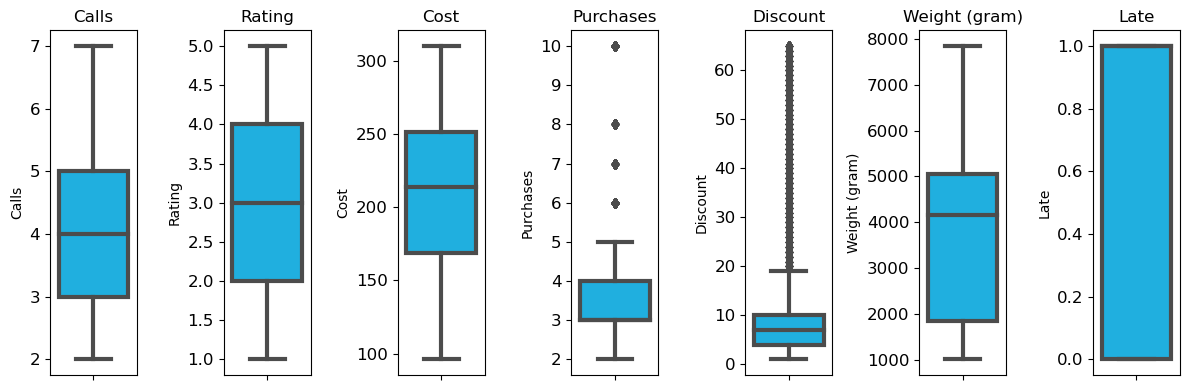

In [24]:
# cek boxplot kolom tipe data int/float untuk melihat outlier

for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(y=df[num[i]], color='deepskyblue', orient='v')
    plt.title(num[i])
    plt.tight_layout()

In [25]:
from scipy import stats

z_scores = np.abs(stats.zscore(df[num]))
outliers = z_scores > 3

# Cek keadaan data setelah outlier dihilangkan
cleaned_df = df[~outliers.any(axis=1)]

# Menampilkan hasil
print("Jumlah outlier:")
print(outliers.sum())

print(f'\nJumlah baris sebelum memfilter outlier: {len(df)}')
print(f'Jumlah baris setelah memfilter outlier: {len(cleaned_df)}')

Jumlah outlier:
Calls              0
Rating             0
Cost               0
Purchases        178
Discount         181
Weight (gram)      0
Late               0
dtype: int64

Jumlah baris sebelum memfilter outlier: 10999
Jumlah baris setelah memfilter outlier: 10642


In [26]:
# Distribusi "Yes" dan "No" pada kolom "Late" di df
df_distribution = df['Late'].value_counts(normalize=True)

# Distribusi "Yes" dan "No" pada kolom "Late" di cleaned_df
cleaned_df_distribution = cleaned_df['Late'].value_counts(normalize=True)

print("Distribusi 'Yes' dan 'No' pada kolom 'Late' di df:")
print(df_distribution)

print("\nDistribusi 'Yes' dan 'No' pada kolom 'Late' di cleaned_df:")
print(cleaned_df_distribution)


Distribusi 'Yes' dan 'No' pada kolom 'Late' di df:
Late
1    0.596691
0    0.403309
Name: proportion, dtype: float64

Distribusi 'Yes' dan 'No' pada kolom 'Late' di cleaned_df:
Late
1    0.590303
0    0.409697
Name: proportion, dtype: float64


- Persentase distribusi ini masih aman, sehingga dapat dipertimbangkan untuk mempertahankan outlier dan menggunakan robust scale

Kita akan menggunakan Z-score filtering (cenderung lebih konservatif)

### D. Feature Transformation


__*Normalisasi*__

In [31]:
from sklearn.preprocessing import MinMaxScaler

norm_df = df.copy()

# Min-Max Scaling
scaler = MinMaxScaler()
norm_df[num] = scaler.fit_transform(df[num])

# Menampilkan skewness sebelum transformasi
skewness_before_norm = df[num].skew()
print("\nSkewness sebelum normalisasi:")
print(skewness_before_norm)

# Periksa skewness setelah normalisasi
skewness_after_norm = norm_df[num].skew()
print("\nSkewness setelah normalisasi:")
print(skewness_after_norm)

# Menghitung pengurangannya
skewness_reduction_norm = skewness_before_norm - skewness_after_norm
print("\nPengurangan skewness setelah normalisasi:")
print(skewness_reduction_norm)



Skewness sebelum normalisasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Skewness setelah normalisasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Pengurangan skewness setelah normalisasi:
Calls            1.831868e-15
Rating          -6.670012e-16
Cost            -4.440892e-16
Purchases        0.000000e+00
Discount         0.000000e+00
Weight (gram)   -3.885781e-16
Late             0.000000e+00
dtype: float64


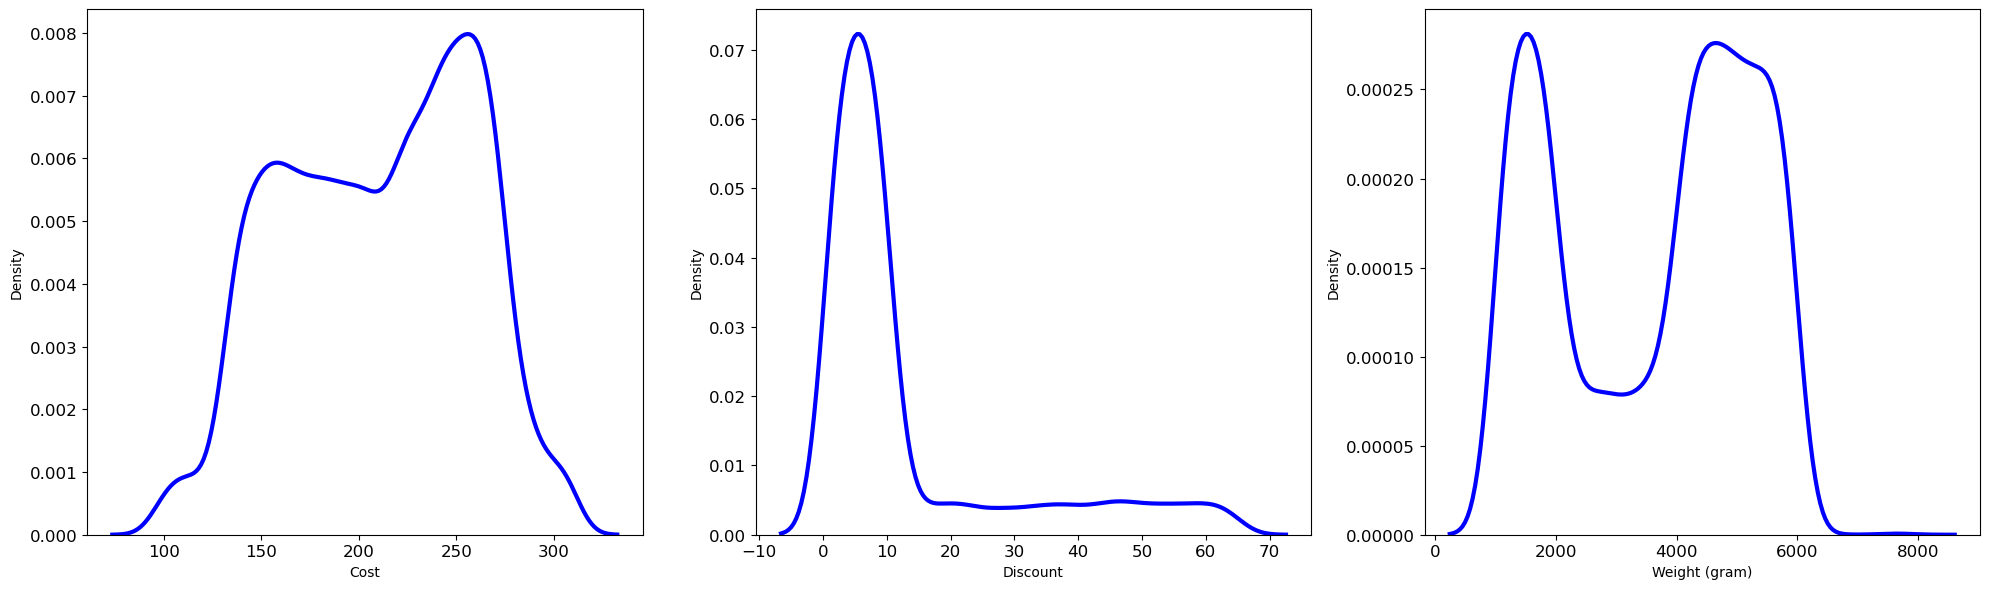

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fitur numerik yang akan ditampilkan distribusinya sebelum normalisasi
num_features = ['Cost', 'Discount', 'Weight (gram)']

# Menampilkan distribusi sebelum normalisasi untuk semua fitur numerik
plt.figure(figsize=(20, 6))
for i in range(0, len(num_features)):
    plt.subplot(1, len(num_features), i+1)
    sns.kdeplot(x=df[num_features[i]], color='blue')
    plt.tight_layout()

plt.show()

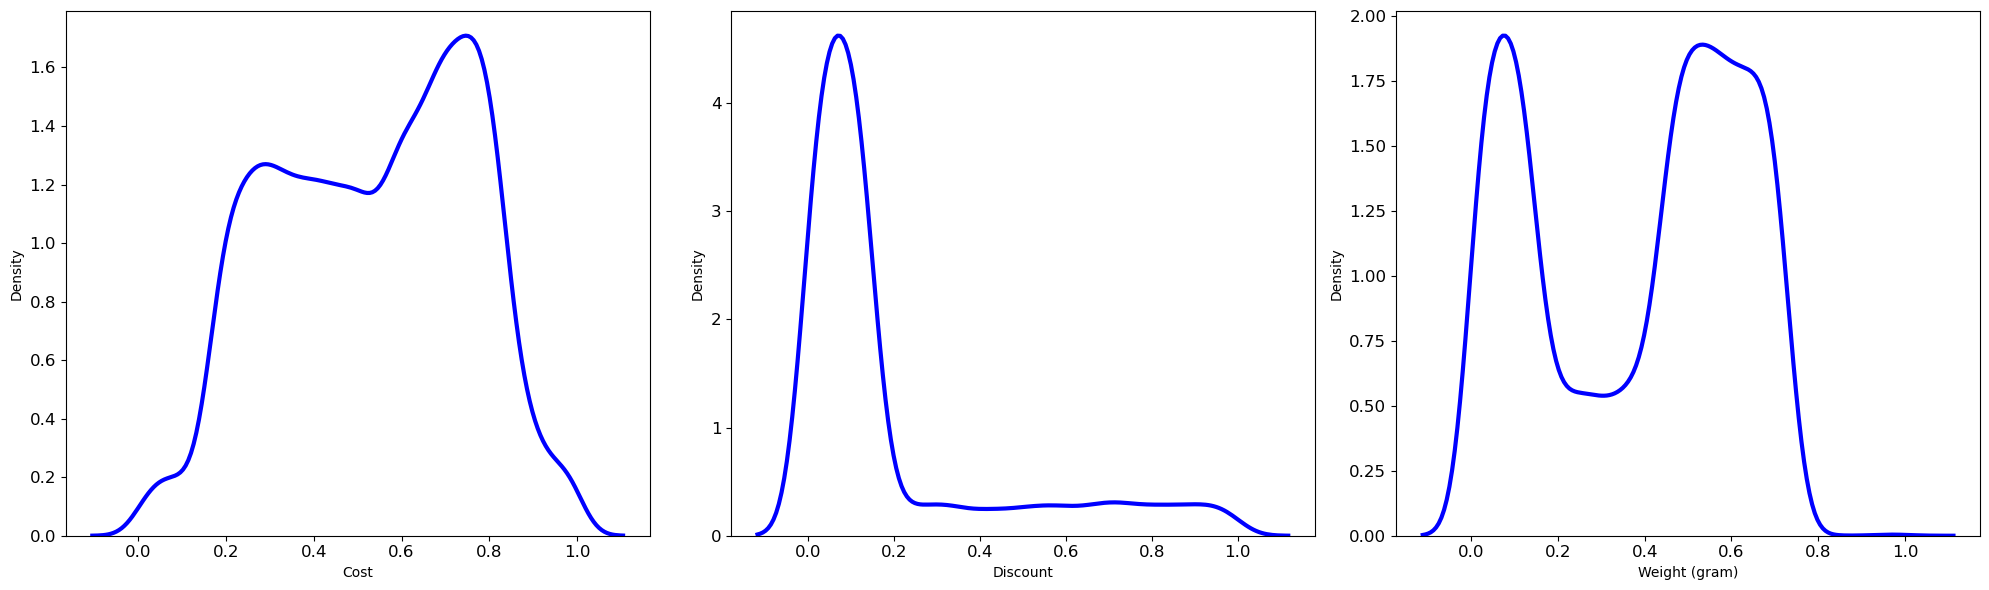

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

num_norm = ['Cost', 'Discount', 'Weight (gram)']

# Menampilkan distribusi setelah normalisasi untuk semua fitur numerik
plt.figure(figsize=(20, 6))
for i in range(0, len(num_norm)):
    plt.subplot(1, len(num_norm), i+1)
    sns.kdeplot(x=norm_df[num_norm[i]], color='blue')
    plt.tight_layout()

plt.show()


- Normalisasi memiliki pengurangan skewness terbesar pada fitur `Calls` dan `Rating`.

### E. Feature Encoding

In [36]:
#melihat feature kategorikal
for col in cat:
  print(f'value counts of column {col}')
  print(df[col].value_counts())
  print('---'*10, '\n')

value counts of column Warehouse
Warehouse
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64
------------------------------ 

value counts of column Shipment
Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64
------------------------------ 

value counts of column Importance
Importance
low       5297
medium    4754
high       948
Name: count, dtype: int64
------------------------------ 

value counts of column Gender
Gender
F    5545
M    5454
Name: count, dtype: int64
------------------------------ 



Strategi encoding<br>
- `importance` : label encoding (kategori ordinal)
- `shipment` & `warehouse` : Berpotensi untuk One Hot Encoding (kategori bukan ordinal)

In [38]:
# Feature Encoding dari Norm
mapping_Importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2,
}
norm_df['Importance'] = norm_df['Importance'].map(mapping_Importance)

In [39]:
norm_df.sample(5)

,ID,Warehouse,Shipment,Calls,Rating,Cost,Purchases,Importance,Gender,Discount,Weight (gram),Late
1884,1885,D,Ship,0.6,0.75,0.808411,0.125,1,F,0.781250,0.352666,1.0
2117,2118,F,Ship,0.2,0.25,0.182243,0.000,1,F,0.015625,0.021768,1.0
6715,6716,F,Flight,0.8,0.75,0.584112,0.375,1,M,0.109375,0.512783,1.0
3236,3237,A,Ship,0.0,1.00,0.630841,0.000,0,F,0.140625,0.497443,1.0
7690,7691,C,Ship,0.4,0.75,0.205607,0.750,1,F,0.015625,0.654492,0.0


### F. Handle Class Imbalance

In [41]:
#cek ratio jumlah nilai target

df_late = df.groupby('Late').agg({'ID':'count'}).reset_index().rename(columns={'ID':'Jumlah'})
df_late['Ratio'] = df_late['Jumlah']*100/df_late['Jumlah'].sum()
df_late

,Late,Jumlah,Ratio
0,0,4436,40.330939
1,1,6563,59.669061


Tidak perlu dilakukan karena proportion of minority class > 40%

## **2. Feature Engineering**

### **A. Feature Selection**

In [45]:
norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10999 non-null  int64  
 1   Warehouse      10999 non-null  object 
 2   Shipment       10999 non-null  object 
 3   Calls          10999 non-null  float64
 4   Rating         10999 non-null  float64
 5   Cost           10999 non-null  float64
 6   Purchases      10999 non-null  float64
 7   Importance     10999 non-null  int64  
 8   Gender         10999 non-null  object 
 9   Discount       10999 non-null  float64
 10  Weight (gram)  10999 non-null  float64
 11  Late           10999 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 1.0+ MB


In [46]:
#melihat kolom int/float/bool

num_dtypes = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']

num_df = norm_df.select_dtypes(include = num_dtypes)
numericals = num_df.columns

print(numericals)

Index(['ID', 'Calls', 'Rating', 'Cost', 'Purchases', 'Importance', 'Discount',
       'Weight (gram)', 'Late'],
      dtype='object')


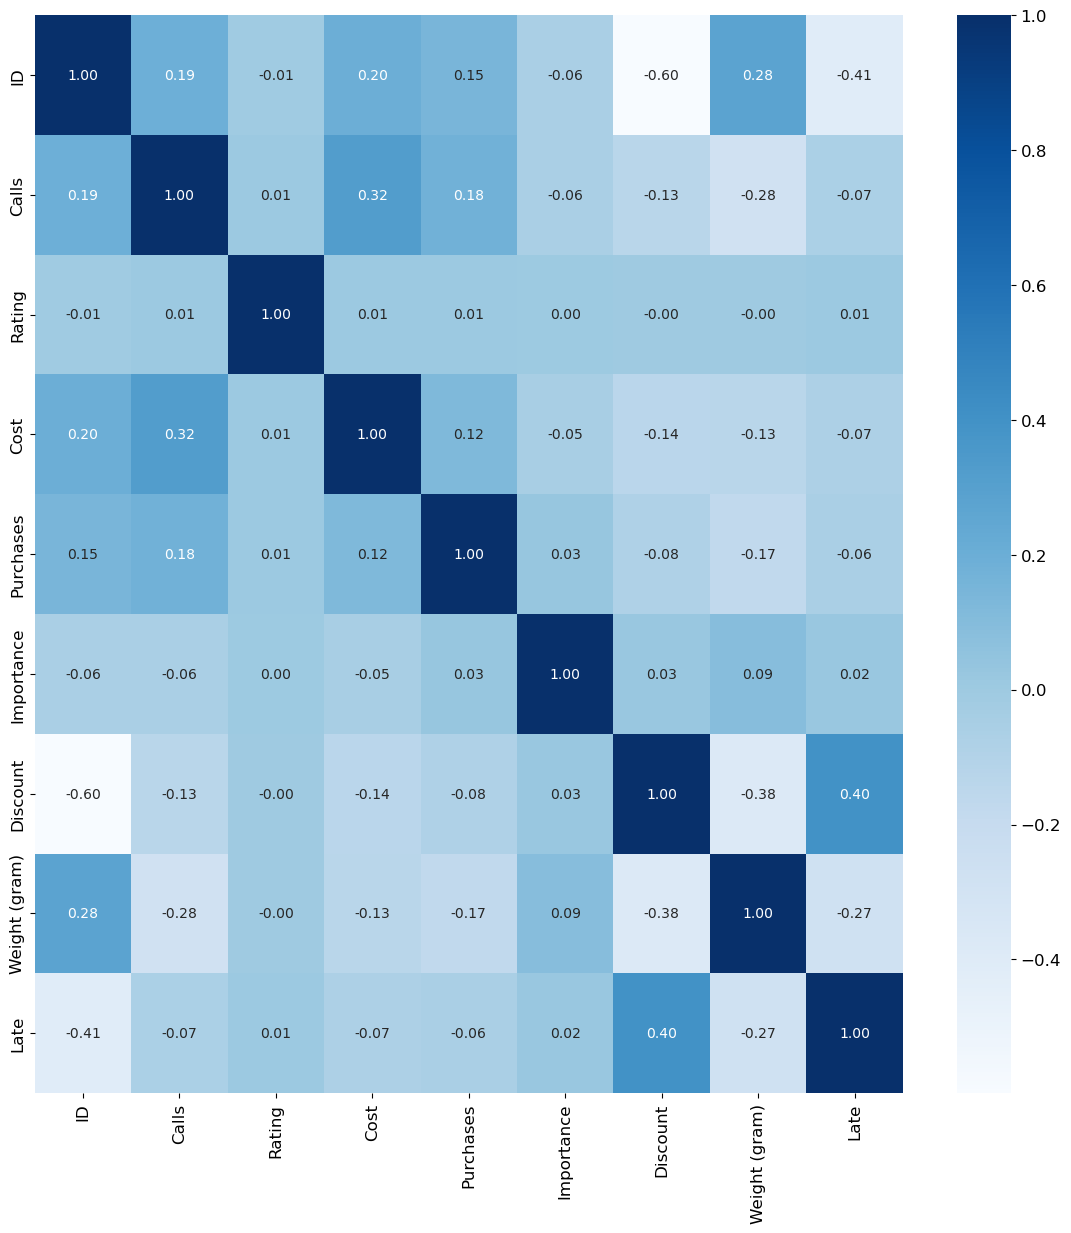

In [47]:
plt.figure(figsize=(14, 14))
sns.heatmap(norm_df[numericals].corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

Analisis Heatmap plot: <br>
- Menghapus feature `ID`, `gender`, dan `rating` dikarenakan feature tersebut tidak memiliki arti penting untuk kegunaan proses modelling.
- Dari heatmap plot, tidak ada feature yang perlu dihapus karena tidak ada feature yang redundant dengan nilai korelasi antar feature > 0.7.

In [49]:
norm_df = norm_df.drop(['ID', 'Rating', 'Gender'], axis=1)

In [50]:
norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Warehouse      10999 non-null  object 
 1   Shipment       10999 non-null  object 
 2   Calls          10999 non-null  float64
 3   Cost           10999 non-null  float64
 4   Purchases      10999 non-null  float64
 5   Importance     10999 non-null  int64  
 6   Discount       10999 non-null  float64
 7   Weight (gram)  10999 non-null  float64
 8   Late           10999 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 773.5+ KB


In [51]:
# #ubah boolean menjadi int (proses one hot, apabila diperlukan)

# boolean = ['Warehouse_A','Warehouse_B','Warehouse_C','Warehouse_D','Warehouse_F','Shipment_Flight','Shipment_Road','Shipment_Ship']

# df[boolean] = df[boolean].astype(int)

### **B. Feature Extraction**

In [53]:
def categorize_purchases(Purchases):
    if Purchases >= 3:
        return 1
    else:
        return 0
norm_df['Reorder_purchases'] = df['Purchases'].apply(categorize_purchases) 
#pengambilan data reorder purchases diambil dari dataset df karena data purchase sudah terkena robust scaling

# Menampilkan kolom 'Purchases' dan 'Reorder_purchase'
print(norm_df[['Purchases', 'Reorder_purchases']])

       Purchases  Reorder_purchases
0          0.125                  1
1          0.000                  0
2          0.250                  1
3          0.250                  1
4          0.125                  1
...          ...                ...
10994      0.375                  1
10995      0.375                  1
10996      0.375                  1
10997      0.500                  1
10998      0.375                  1

[10999 rows x 2 columns]


- Ekstrasi fitur `Reorder_purchases` dengan catatan prior purchases (yes/no), >= 3 : yes (1) dan < 3 : no (0)

### **Optimisasi**

In [57]:
# Drop kolom 'Warehouse' dan 'Shipment'
df_model = norm_df.drop(['Warehouse', 'Shipment'], axis=1)

In [61]:
# Export DataFrame ke dalam file CSV
df_model.to_csv('train_prototipe.csv', index=False)

- Drop Kolom `Warehouse` dan `Shipment` untuk menjadikannya dataset yang siap untuk dimasukan ke dalam model, export ke dalam csv 

In [63]:
df_model.sample(10)

,Calls,Cost,Purchases,Importance,Discount,Weight (gram),Late,Reorder_purchases
6161,0.4,0.677570,0.125,1,0.078125,0.519649,0.0,1
8738,0.4,0.467290,0.125,1,0.109375,0.663258,0.0,1
5801,0.8,0.373832,0.125,0,0.140625,0.629072,0.0,1
2339,0.6,0.476636,0.000,1,0.562500,0.295690,1.0,0
7981,0.4,0.570093,0.000,1,0.031250,0.589920,0.0,0
2402,0.2,0.126168,0.250,1,0.093750,0.086925,1.0,1
2654,0.0,0.252336,0.125,0,0.234375,0.107670,1.0,1
5235,0.6,0.714953,0.125,2,0.109375,0.584222,1.0,1
6267,0.4,0.612150,0.375,0,0.015625,0.117312,1.0,1
4670,0.4,0.728972,0.000,1,0.078125,0.644704,0.0,0


## *APPENDIX*
